# Chain Manipulator SubSystem

Investigate a way to incorporate closed form FK for *massless* chain mechanisms and its Jacobian $J(\theta)$, e.g., the leg of a robot or a 7DOF arm, etc. Because $\mathcal{F} = \tau J(\theta)$, we then also have closed form inverse dynamics.

In [1]:
from pathlib import Path
import numpy as np
from typing import Optional

import gtdynamics as gtd
from gtsam import Pose3, Values, Rot3, Point3

import roboplot  # type: ignore
%matplotlib widget

from prototype.chain import Chain

In [2]:
model_file = Path(gtd.URDF_PATH) / "panda" / "panda.urdf"
base_name = "link0"
# Crucial to fix base link or FK gives wrong result
robot = gtd.CreateRobotFromFile(str(model_file)).fixLink(base_name)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
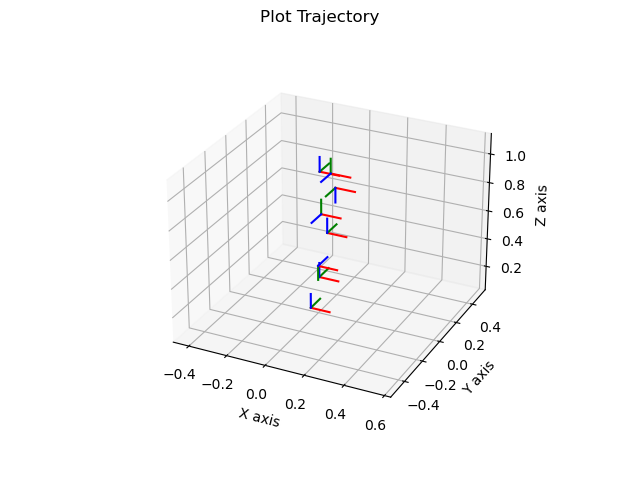

In [3]:
# Check FK at rest
joint_angles = Values()
for i in range(7):
    gtd.InsertJointAngle(joint_angles, i, 0.0)

# Conventional FK with GTSAM
fk = robot.forwardKinematics(joint_angles, 0, base_name)

# Display link poses.
roboplot.plot_trajectory(fk, fignum=4, scale=0.1, show=True);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
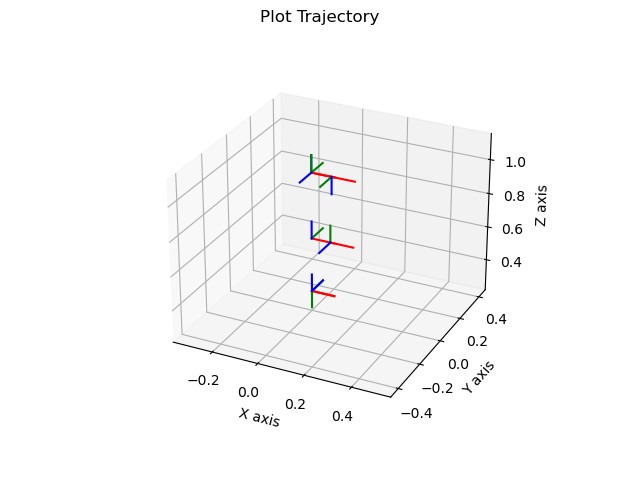

In [ ]:
# Display joint poses in base frame.
joint_poses = Values()
joints = robot.joints()
for i in range(7): 
    pMj = joints[i].pMj()
    gtd.InsertPose(joint_poses, i, gtd.Pose(fk, i).compose(pMj))
roboplot.plot_trajectory(joint_poses, fignum=3, scale=0.1, show=True);

In [5]:
def JointAngles(q: list):
    """Create Values with joint angles."""
    joint_angles = Values()
    for j, q_j in enumerate(q):
        gtd.InsertJointAngle(joint_angles, j, q_j)
    return joint_angles

In [6]:
chain = Chain.from_robot(robot, base_name)
q = [0.1, -0.2, 0.3, -0.4, 0.5, -0.6, 0.7]
joint_angles = JointAngles(q)

In [16]:
# Calculate torques from applied wrench, e.g. force in X direction:
Je = np.empty((6,7))
sTe = chain.poe(q=np.array(q), J=Je)
Fe_applied = np.array([0,0,0,1,0,0], float)
tau = Fe_applied @ Je
print(f"tau={np.round(tau,3)}")

tau=[-0.036  0.469 -0.037 -0.188 -0.012  0.076  0.002]


In [7]:
%%timeit
# Conventional FK with GTSAM.
fk = robot.forwardKinematics(joint_angles, 0, base_name)

10.7 µs ± 705 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
%%timeit
# FK with POE.
sTe = chain.poe(q=np.array(q))

14.9 µs ± 214 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
